Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   _id             312 non-null    object
 1   content         312 non-null    object
 2   sender          312 non-null    object
 3   intent          312 non-null    object
 4   assistThreadId  312 non-null    object
 5   candidateId     300 non-null    object
 6   botMessageId    312 non-null    object
 7   botThreadId     312 non-null    object
 8   createdAt       312 non-null    object
 9   citations       156 non-null    object
 10  companyId       244 non-null    object
 11  jobId           198 non-null    object
dtypes: object(12)
memory usage: 29.4+ KB
None

Sample Messages:
0      Is my salary range meeting market expectations?
1    To determine if your salary range is meeting m...
2              What type of roles would be a good fit?
3    Based on the ENTP personality 

100%|██████████| 312/312 [00:00<00:00, 1578.86it/s]


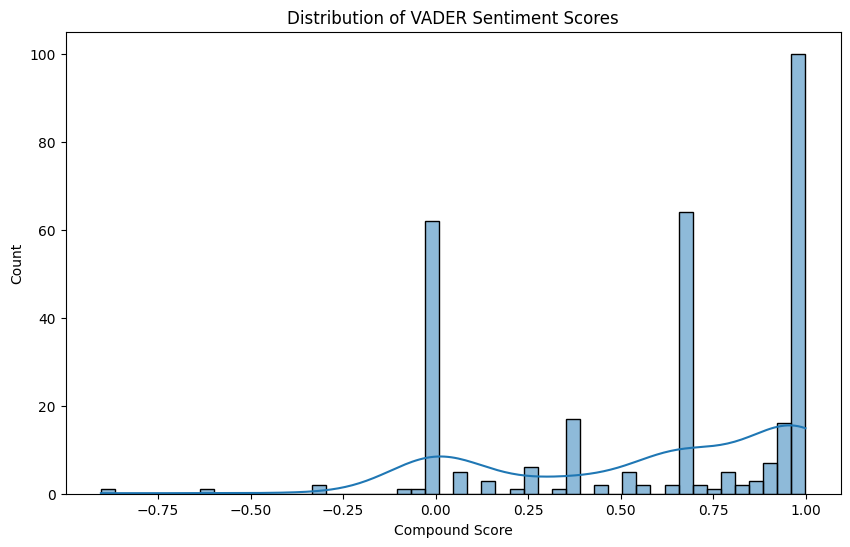


VADER Sentiment Distribution:
vader_sentiment
positive    0.782051
neutral     0.198718
negative    0.019231
Name: proportion, dtype: float64

Using device: GPU for RoBERTa analysis.


config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

c:\Users\MR.Laptops\OneDrive - purdue.edu\Desktop\IP\text analysis\venv\Lib\site-packages\huggingface_hub\file_download.py:144: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\MR.Laptops\.cache\huggingface\hub\models--cardiffnlp--twitter-roberta-base-sentiment. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

Device set to use cuda:0


Analyzing sentiments using RoBERTa (batch size: 32)...


100%|██████████| 10/10 [00:06<00:00,  1.64it/s]


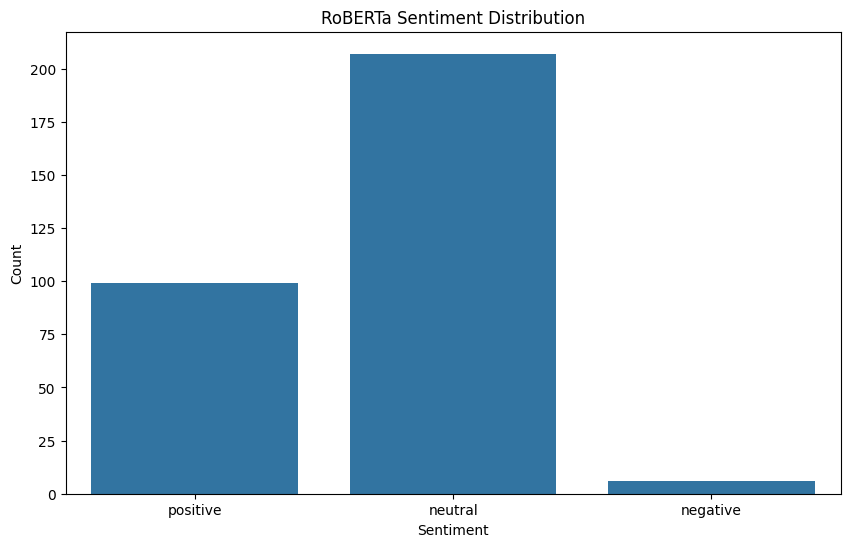


RoBERTa Sentiment Distribution:
roberta_sentiment
neutral     0.663462
positive    0.317308
negative    0.019231
Name: proportion, dtype: float64

Applying custom weighted sentiment analysis...


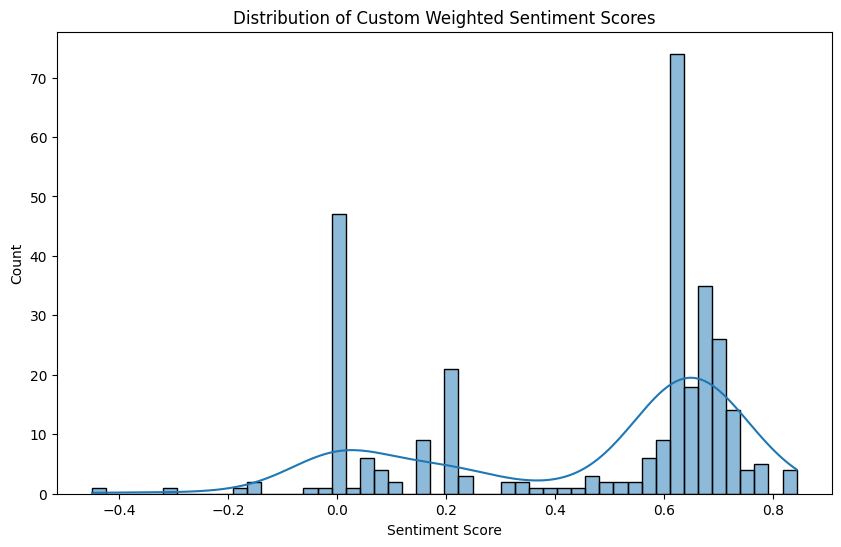


Custom Weighted Sentiment Distribution:
custom_sentiment_label
positive    0.807692
neutral     0.176282
negative    0.016026
Name: proportion, dtype: float64

Plotting sentiment comparison...


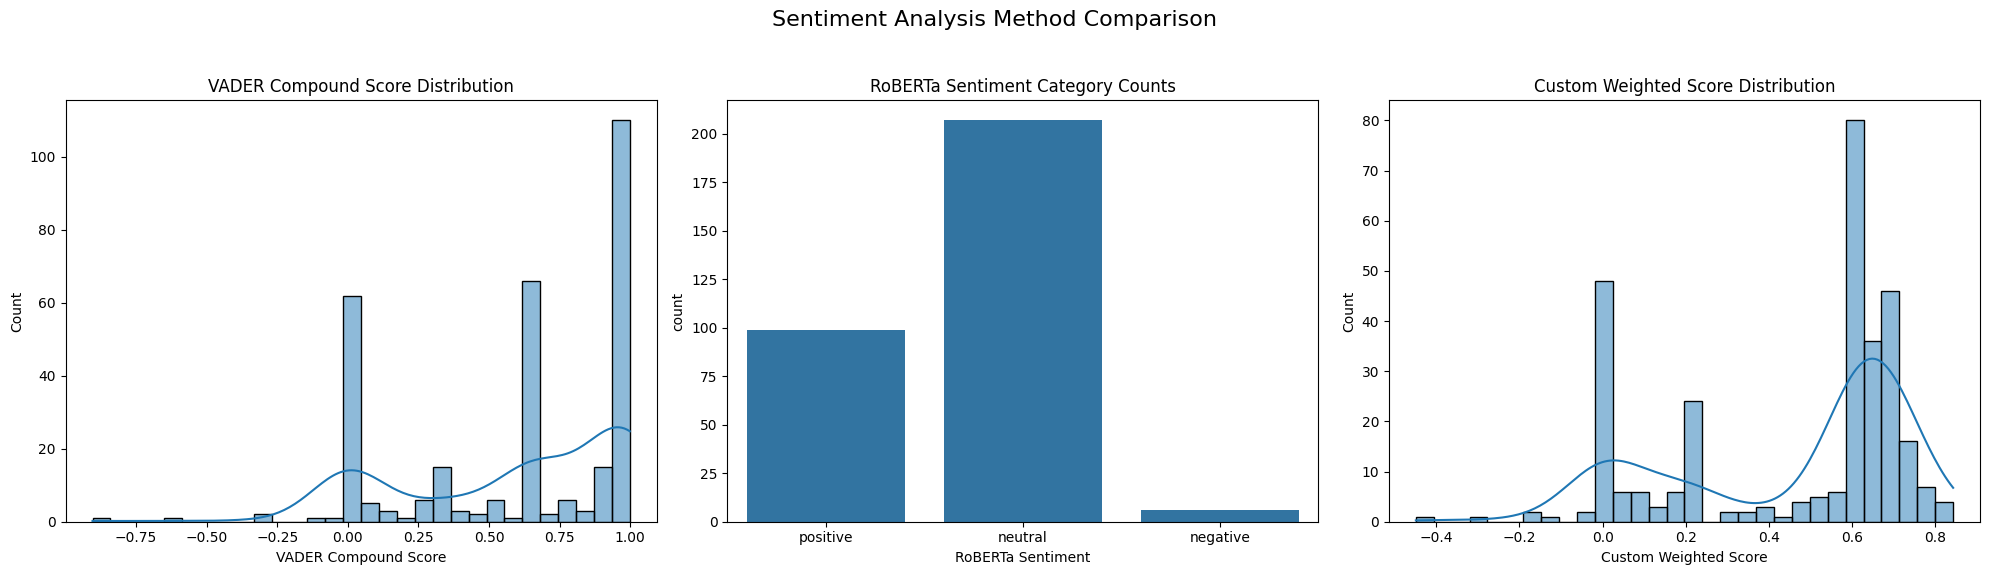

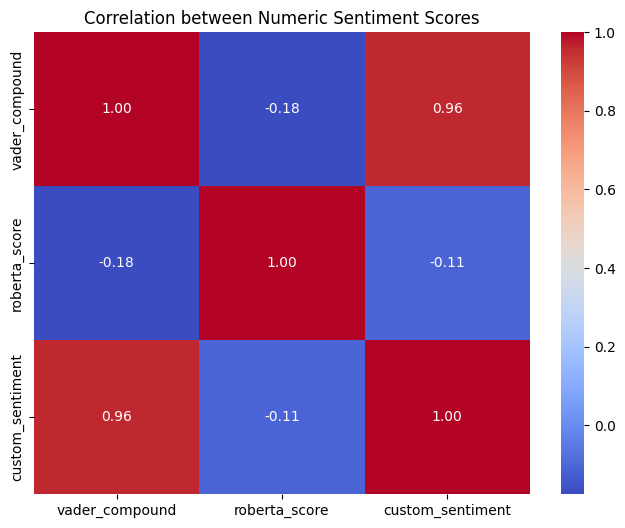


Analyzing average sentiment by intent...


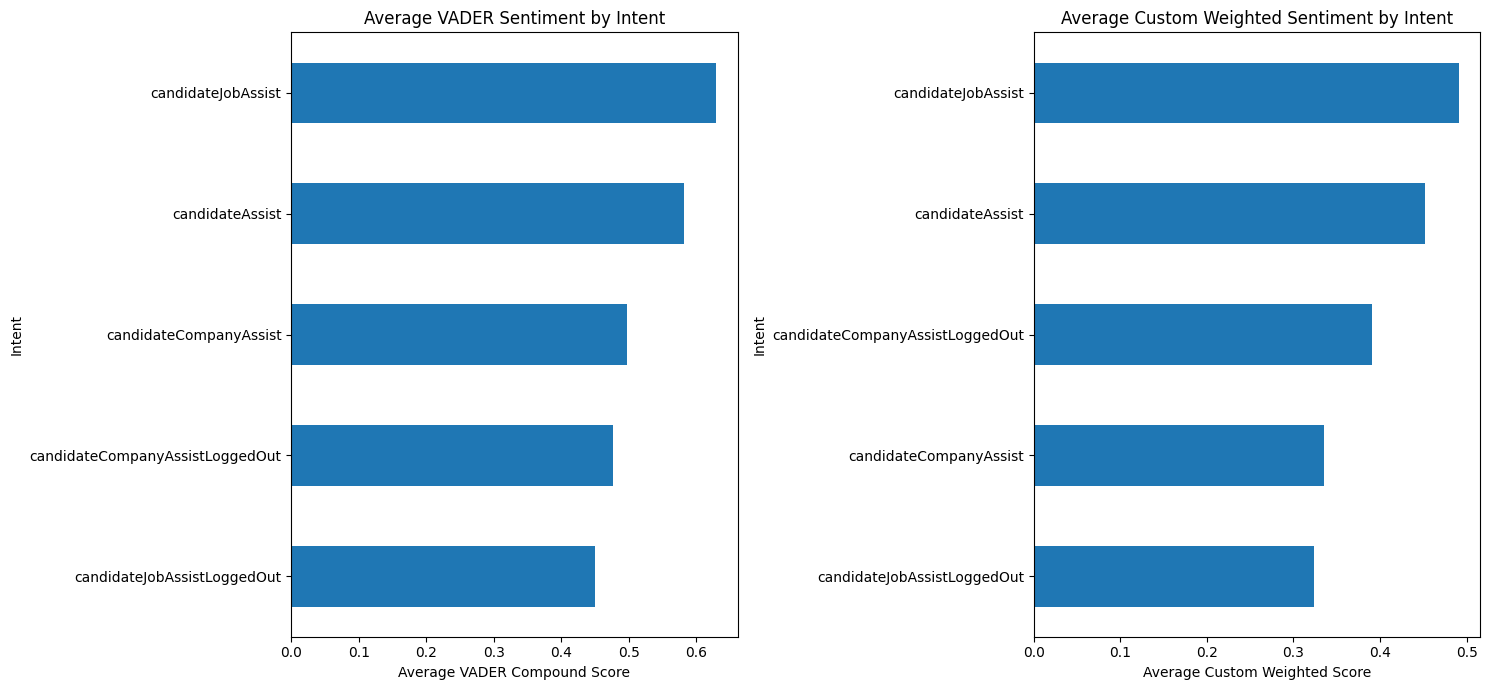


Script finished.


In [1]:
# # Sentiment Analysis
#
# This notebook implements sentiment analysis on the conversation dataset using various approaches including:
# 1. VADER Sentiment Analysis
# 2. Transformer-based sentiment analysis (RoBERTa)
# 3. Custom weighted sentiment analysis

# Import required libraries
import json
import pandas as pd
import numpy as np
from datetime import datetime
import torch
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from textblob import TextBlob


# ## 1. Data Loading and Initial Analysis

# Load the JSON data
def load_data(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return pd.DataFrame(data)

# Load the dataset
# Note: You might need to change 'Parallel-Prod.AssistMessage.json'
# to the actual path of your data file.
try:
    df = load_data('Parallel-Prod.AssistMessage.json')

    # Display basic information
    print("Dataset Info:")
    print(df.info())
    print("\nSample Messages:")
    print(df['content'].head())

except FileNotFoundError:
    print("Error: Data file 'Parallel-Prod.AssistMessage.json' not found.")
    print("Please ensure the file exists in the correct directory or update the path.")
    # Create a dummy DataFrame to allow the rest of the script to run without errors
    # You should replace this with your actual data loading logic if the file path is different.
    df = pd.DataFrame({
        'content': [
            "This is a great positive example!",
            "This is a terrible negative example.",
            "This is just a neutral statement.",
            "I am very happy today.",
            "I feel quite sad about this."
        ],
        'intent': [
            'positive_feedback',
            'negative_feedback',
            'neutral_statement',
            'positive_emotion',
            'negative_emotion'
        ]
    })
    print("\nUsing dummy data for demonstration as the original file was not found.")


# ## 2. VADER Sentiment Analysis

def analyze_vader_sentiment(texts):
    analyzer = SentimentIntensityAnalyzer()
    sentiments = []

    for text in tqdm(texts):
        vs = analyzer.polarity_scores(text)
        sentiments.append(vs)

    return pd.DataFrame(sentiments)

# Analyze sentiments using VADER
print("\nAnalyzing sentiments using VADER...")
vader_results = analyze_vader_sentiment(df['content'])

# Add results to dataframe
df['vader_compound'] = vader_results['compound']
df['vader_sentiment'] = df['vader_compound'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)

# Plot VADER sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='vader_compound', bins=50, kde=True)
plt.title('Distribution of VADER Sentiment Scores')
plt.xlabel('Compound Score')
plt.ylabel('Count')
plt.show()

# Display sentiment distribution
print("\nVADER Sentiment Distribution:")
print(df['vader_sentiment'].value_counts(normalize=True))


# ## 3. RoBERTa-based Sentiment Analysis

def analyze_roberta_sentiment(texts, batch_size=32):
    # Load RoBERTa sentiment analysis pipeline
    # Use CUDA if available, otherwise CPU
    device = 0 if torch.cuda.is_available() else -1
    print(f"\nUsing device: {'GPU' if device == 0 else 'CPU'} for RoBERTa analysis.")
    try:
        sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model="cardiffnlp/twitter-roberta-base-sentiment",
            device=device
        )
    except Exception as e:
        print(f"Error loading RoBERTa model: {e}")
        print("Skipping RoBERTa analysis.")
        return None

    results = []
    print(f"Analyzing sentiments using RoBERTa (batch size: {batch_size})...")
    # Ensure texts is a list of strings
    texts_list = [str(text) for text in texts.tolist()]
    for i in tqdm(range(0, len(texts_list), batch_size)):
        batch = texts_list[i:i + batch_size]
        # Truncate long texts if necessary, RoBERTa has a max sequence length (often 512)
        truncated_batch = [text[:512] for text in batch]
        try:
            outputs = sentiment_pipeline(truncated_batch)
            results.extend(outputs)
        except Exception as e:
            print(f"\nError processing batch starting at index {i}: {e}")
            # Add placeholders for failed batch items
            results.extend([{'label': 'error', 'score': 0.0}] * len(batch))

    return pd.DataFrame(results)

# Analyze sentiments using RoBERTa
roberta_results = analyze_roberta_sentiment(df['content'])

if roberta_results is not None:
    # Map RoBERTa labels to match VADER/Custom (positive, negative, neutral)
    label_map = {
        'LABEL_0': 'negative', # Example mapping, adjust based on model output
        'LABEL_1': 'neutral',
        'LABEL_2': 'positive',
        'error': 'error' # Handle potential errors during analysis
    }
    # Check if 'label' column exists before applying mapping
    if 'label' in roberta_results.columns:
        df['roberta_sentiment'] = roberta_results['label'].map(label_map).fillna('unknown')
        df['roberta_score'] = roberta_results['score']

        # Plot RoBERTa sentiment distribution
        plt.figure(figsize=(10, 6))
        # Ensure 'roberta_sentiment' column exists and has valid data for plotting
        if 'roberta_sentiment' in df.columns and not df['roberta_sentiment'].isin(['error', 'unknown']).all():
           sns.countplot(data=df, x='roberta_sentiment', order=['positive', 'neutral', 'negative'])
           plt.title('RoBERTa Sentiment Distribution')
           plt.xlabel('Sentiment')
           plt.ylabel('Count')
           plt.show()

           # Display sentiment distribution
           print("\nRoBERTa Sentiment Distribution:")
           print(df['roberta_sentiment'].value_counts(normalize=True))
        else:
            print("\nSkipping RoBERTa distribution plot due to errors or missing data.")

    else:
        print("\n'label' column not found in RoBERTa results. Skipping RoBERTa analysis integration.")
        df['roberta_sentiment'] = 'not_analyzed'
        df['roberta_score'] = np.nan


# ## 4. Custom Weighted Sentiment Analysis

def custom_weighted_sentiment(text):
    # Ensure text is a string
    text = str(text)
    # Get sentiment scores from different methods
    vader_analyzer = SentimentIntensityAnalyzer()
    vader = vader_analyzer.polarity_scores(text)['compound']
    textblob = TextBlob(text).sentiment.polarity

    # Weighted combination
    weights = {
        'vader': 0.6,
        'textblob': 0.4
    }

    weighted_score = (
        vader * weights['vader'] +
        textblob * weights['textblob']
    )

    return weighted_score

# Apply custom sentiment analysis
print("\nApplying custom weighted sentiment analysis...")
df['custom_sentiment'] = df['content'].apply(custom_weighted_sentiment)
df['custom_sentiment_label'] = df['custom_sentiment'].apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral')
)


# Plot custom sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='custom_sentiment', bins=50, kde=True)
plt.title('Distribution of Custom Weighted Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Count')
plt.show()

# Display custom sentiment distribution
print("\nCustom Weighted Sentiment Distribution:")
print(df['custom_sentiment_label'].value_counts(normalize=True))


# ## 5. Comparative Analysis

# Compare different sentiment analysis methods
def plot_sentiment_comparison(df_results):
    fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=False)
    fig.suptitle('Sentiment Analysis Method Comparison', fontsize=16)

    # VADER Distribution
    sns.histplot(data=df_results, x='vader_compound', bins=30, ax=axes[0], kde=True)
    axes[0].set_title('VADER Compound Score Distribution')
    axes[0].set_xlabel('VADER Compound Score')

    # RoBERTa Distribution (Count Plot)
    if 'roberta_sentiment' in df_results.columns and not df_results['roberta_sentiment'].isin(['error', 'unknown', 'not_analyzed']).all():
        order = ['positive', 'neutral', 'negative'] # Define order for consistency
        sns.countplot(data=df_results, x='roberta_sentiment', ax=axes[1], order=[l for l in order if l in df_results['roberta_sentiment'].unique()])
        axes[1].set_title('RoBERTa Sentiment Category Counts')
        axes[1].set_xlabel('RoBERTa Sentiment')
    else:
        axes[1].text(0.5, 0.5, 'RoBERTa data not available', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
        axes[1].set_title('RoBERTa Sentiment (Unavailable)')


    # Custom Weighted Distribution
    sns.histplot(data=df_results, x='custom_sentiment', bins=30, ax=axes[2], kde=True)
    axes[2].set_title('Custom Weighted Score Distribution')
    axes[2].set_xlabel('Custom Weighted Score')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

print("\nPlotting sentiment comparison...")
plot_sentiment_comparison(df)

# Calculate correlation between different methods' numerical scores
# Only include columns that exist and have numeric data
corr_cols = ['vader_compound', 'custom_sentiment']
if 'roberta_score' in df.columns and pd.api.types.is_numeric_dtype(df['roberta_score']):
    # Drop rows where roberta_score might be NaN before calculating correlation
    valid_roberta_df = df.dropna(subset=['roberta_score'])
    if not valid_roberta_df.empty:
         # Need to re-align indices if we drop NaNs only for RoBERTa
         # A simpler approach for correlation is to select columns first, then dropna
         corr_df = df[['vader_compound', 'roberta_score', 'custom_sentiment']].dropna()
         if not corr_df.empty:
             correlation_matrix = corr_df.corr()
             plt.figure(figsize=(8, 6))
             sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
             plt.title('Correlation between Numeric Sentiment Scores')
             plt.show()
         else:
             print("\nNot enough valid numeric data across methods to calculate correlation.")

    else:
       print("\nRoBERTa scores are all NaN, cannot calculate correlation including it.")
       correlation_matrix = df[['vader_compound', 'custom_sentiment']].dropna().corr()
       plt.figure(figsize=(8, 6))
       sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
       plt.title('Correlation between VADER and Custom Scores')
       plt.show()

else:
    print("\nRoBERTa score column not available or not numeric for correlation analysis.")
    correlation_matrix = df[['vader_compound', 'custom_sentiment']].dropna().corr()
    if not correlation_matrix.empty:
        plt.figure(figsize=(8, 6))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title('Correlation between VADER and Custom Scores')
        plt.show()
    else:
        print("\nNot enough data to calculate correlation between VADER and Custom scores.")


# ## 6. Sentiment Analysis by Categories (Example: by 'intent')

# Analyze sentiment patterns by intent (if 'intent' column exists)
def analyze_sentiment_by_category(df_results):
    if 'intent' not in df_results.columns:
        print("\n'intent' column not found in DataFrame. Skipping analysis by category.")
        return

    print("\nAnalyzing average sentiment by intent...")
    # Calculate average sentiment by intent, handling potential non-numeric data
    numeric_cols = ['vader_compound', 'custom_sentiment']
    # Ensure columns are numeric before grouping
    for col in numeric_cols:
        df_results[col] = pd.to_numeric(df_results[col], errors='coerce')

    # Drop rows where key sentiment scores are NaN before grouping
    sentiment_by_intent = df_results.dropna(subset=numeric_cols).groupby('intent')[
        numeric_cols
    ].mean()

    if sentiment_by_intent.empty:
        print("No valid numeric sentiment data found after grouping by intent.")
        return

    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 7)) # Increased height for better label visibility

    if 'vader_compound' in sentiment_by_intent.columns:
        sentiment_by_intent['vader_compound'].sort_values().plot(
            kind='barh', # Horizontal bar chart for better readability with many categories
            ax=axes[0],
            title='Average VADER Sentiment by Intent'
        )
        axes[0].set_xlabel('Average VADER Compound Score')
        axes[0].set_ylabel('Intent')
    else:
        axes[0].text(0.5, 0.5, 'VADER data unavailable', ha='center', va='center', transform=axes[0].transAxes)
        axes[0].set_title('Average VADER Sentiment by Intent')


    if 'custom_sentiment' in sentiment_by_intent.columns:
        sentiment_by_intent['custom_sentiment'].sort_values().plot(
            kind='barh', # Horizontal bar chart
            ax=axes[1],
            title='Average Custom Weighted Sentiment by Intent'
        )
        axes[1].set_xlabel('Average Custom Weighted Score')
        axes[1].set_ylabel('Intent')
    else:
        axes[1].text(0.5, 0.5, 'Custom data unavailable', ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Average Custom Weighted Sentiment by Intent')

    plt.tight_layout()
    plt.show()

# Check if the 'intent' column exists before calling the function
if 'intent' in df.columns:
    analyze_sentiment_by_category(df)
else:
    print("\nSkipping sentiment analysis by category as 'intent' column is missing.")

print("\nScript finished.")



# Analysis of Sentiment Analysis Method Comparison

These images compare three different sentiment analysis methods applied to the same dataset, likely on recruitment-related texts.

## First Image: Distribution of Sentiment Scores

The first image shows how each method categorizes sentiment differently:

1. **VADER Compound Score** (left):
   - Shows a multi-modal distribution with peaks at around 0.0, 0.25, 0.75, and 1.0
   - A large concentration of scores at 1.0 (very positive)
   - Relatively few negative scores (below 0)

2. **RoBERTa Sentiment Categories** (middle):
   - Uses categorical sentiment rather than continuous scores
   - Most texts classified as "neutral" (~200 documents)
   - About half as many classified as "positive" (~100 documents)
   - Very few classified as "negative" (~5 documents)

3. **Custom Weighted Score** (right):
   - Shows peaks at 0.0 and around 0.6-0.7
   - Distribution pattern somewhat similar to VADER but with different scaling
   - More balanced distribution across the range

## Second Image: Correlation Between Methods

The heatmap shows correlations between the three methods:

- **VADER and Custom Sentiment** have extremely high correlation (0.96), meaning they largely agree
- **RoBERTa scores** are negatively correlated with both VADER (-0.18) and Custom (-0.11) methods

## What's Causing the Differences

The key differences appear to be:

1. **Different underlying algorithms**:
   - VADER is a rule-based sentiment analyzer specifically tuned for social media
   - RoBERTa is a transformer-based deep learning model trained on general text
   - Custom Weighted approach likely combines multiple methods or is tailored to your specific domain

2. **Scale interpretation**:
   - RoBERTa uses discrete categories (positive/neutral/negative)
   - VADER and Custom use continuous scores but with different scales
   - The negative correlation with RoBERTa suggests it might be interpreting neutrality differently

3. **Domain specificity**:
   - Recruitment text often contains professional, formal language that may be challenging for general-purpose sentiment analyzers
   - Industry-specific terminology might be scored differently by each method
   - RoBERTa appears more conservative, classifying most content as neutral

4. **Threshold differences**:
   - VADER has more documents classified at extreme positive values
   - RoBERTa seems to have a higher threshold for classifying text as positive or negative
   - Custom method shows a more nuanced distribution, suggesting industry-specific tuning

The high agreement between VADER and Custom models despite their different distributions suggests they're detecting similar sentiment patterns but expressing them on different scales. The RoBERTa model is clearly taking a different approach, which may be due to its training on more general language patterns rather than industry-specific content.

For recruitment data, this difference matters because professional communication often uses subtle sentiment indicators that general models might miss or classify as neutral.
